In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from py_ephys.utils import EphysSweepSetFeatureExtractor, strip_info
from py_ephys.features import * # contains available the features
from py_ephys.diagnostics import * # contains available diagnostics

import jupyter_black

jupyter_black.load()

In [2]:
# load test data
test_data = np.load("tests/test_sweepset.npz", allow_pickle=True)
t_set, u_set, i_set = test_data["ts"], test_data["Uts"], test_data["Its"]
t_set *= 1e-3  # ms -> s
start, end = t_set[0, 0], t_set[0, -1]
dc_offset = -14.520833986604785

# each sweep should be a Tuple of numpy arrays (t, u, i) containing time (s),
# voltage (mV), and stimulus current (pA) arrays of shape (1, n_samples)
# dc_offset is the holding current (defaults to 0 if not supplied)

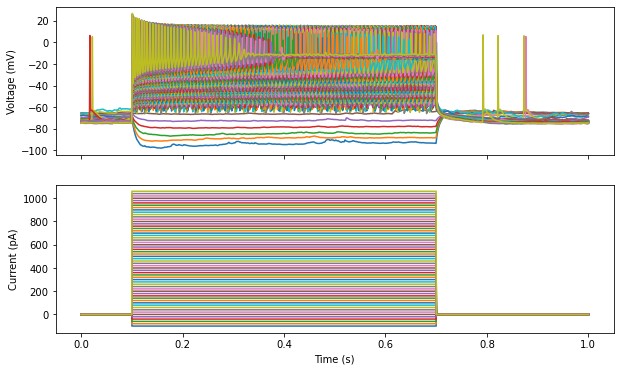

In [3]:
# what the data looks like
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axes[0].plot(t_set.T, u_set.T)
axes[0].set_ylabel("Voltage (mV)")
axes[1].plot(t_set.T, i_set.T)
axes[1].set_ylabel("Current (pA)")
axes[1].set_xlabel("Time (s)")
plt.show()

In [4]:
# create sweepset
test_sweepset = EphysSweepSetFeatureExtractor(
    t_set, u_set, i_set, filter=1, dc_offset=-10
)

test_sweep = test_sweepset.sweeps()[13]

print("Available spike features:", list(get_available_spike_features().keys()))
print("Available sweep features:", list(get_available_sweep_features().keys()))
print("Available sweepset features:", list(get_available_sweepset_features().keys()))

Available spike features: ['peak_height', 'ahp', 'adp']
Available sweep features: ['stim_amp', 'stim_onset', 'stim_end', 'ap_latency', 'v_baseline', 'v_deflect', 'tau', 'num_ap', 'ap_freq', 'ap_freq_adapt', 'ap_amp_slope', 'r_input', 'sag', 'sag_fraction', 'sag_ratio', 'sag_area', 'sag_time', 'v_plateau', 'rebound', 'rebound_aps', 'rebound_area', 'rebound_latency', 'rebound_avg', 'v_rest', 'num_bursts', 'burstiness', 'wildness', 'ahp', 'adp', 'ap_thresh', 'ap_amp', 'ap_width', 'ap_peak', 'ap_trough', 'udr']
Available sweepset features: ['tau', 'r_input', 'v_rest', 'v_baseline', 'slow_hyperpolarization', 'sag', 'sag_ratio', 'sag_fraction', 'sag_area', 'sag_time', 'rebound', 'rebound_aps', 'rebound_area', 'rebound_latency', 'rebound_avg', 'num_ap', 'ap_freq', 'wildness', 'ap_freq_adapt', 'ap_amp_slope', 'fano_factor', 'ap_fano_factor', 'cv', 'ap_cv', 'burstiness', 'num_bursts', 'isi_adapt', 'isi_adapt_avg', 'ap_amp_adapt', 'ap_amp_adapt_avg', 'ap_latency', 'ahp', 'adp', 'ap_thresh', 'ap_

In [5]:
# compute spike features from py_ephys.features and AllenSDK for single sweep
test_sweep.process_spikes()

# Note that some features depend on others, which need to be computed first.
# See feature docstrings for details
print("Height of first AP = ", get_spike_peak_height(test_sweep)[0])
print("Stimulus amplitude = ", get_sweep_stim_amp(test_sweep))

# You can return diagnostic information about sweep features by setting return_ft_info=True
print(
    f"Height of first AP = {get_sweep_stim_amp(test_sweep, return_ft_info=True)}\n",
)

# compute ap latency and dependent features
get_sweep_stim_amp(test_sweep, return_ft_info=True, update_inplace=True)
get_sweep_stim_onset(test_sweep, return_ft_info=True, update_inplace=True)
get_sweep_stim_end(test_sweep, return_ft_info=True, update_inplace=True)


ap_latency = (
    get_sweep_ap_latency(test_sweep, return_ft_info=True, update_inplace=True)["value"]
    * 1000
)  # ms
print(f"ap_latency = {ap_latency:.3f} ms")

Height of first AP =  53.803385521564955
Stimulus amplitude =  160.0
Height of first AP = {'value': 160.0, 'idx_amp': 2501, 't_amp': 0.10003999999999998, 'description': 'maximum amplitude of stimulus.'}

ap_latency = 20.640 ms


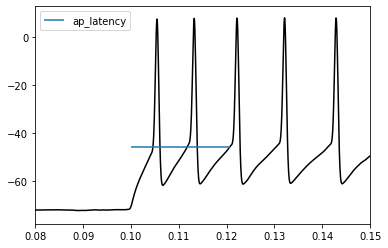

/home/jnsbck/Applications/anaconda3/envs/ml/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


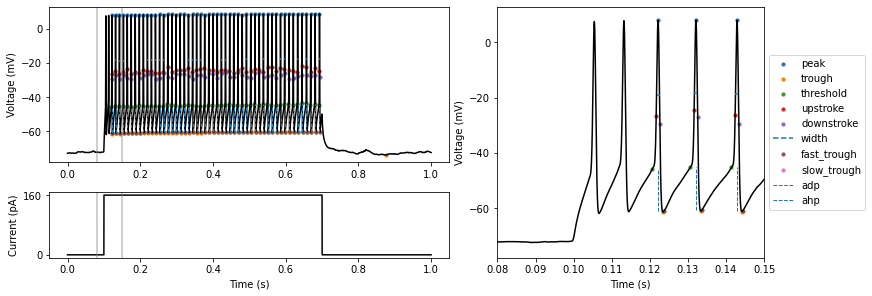

In [6]:
# The ap_latency is unexpectedly large. Let's see what's going on

# plotting the diagnostics for ap_latency reveals that the first two APs are being skipped
fig, ax = plt.subplots()
ax.plot(test_sweep.t, test_sweep.v, "k")
plot_sweep_ap_latency(test_sweep, ax)
ax.legend()
ax.set_xlim(0.08, 0.15)
plt.show()

# plotting the spike features for this trace reveals why:
# The first two APs are not being detected / have no features.
plot_spike_diagnostics(test_sweep, [0.08, 0.15])
plt.show()

In [7]:
# We can also compute features for the whole set of sweeps.

# add available spike, sweep and sweepset features to sweepsetextractor
test_sweepset.set_stimulus_amplitude_calculator(get_sweep_stim_amp)
for ft, ft_func in get_available_spike_features().items():
    test_sweepset.add_spike_feature(ft, ft_func)
for ft, ft_func in get_available_sweep_features(return_ft_info=True).items():
    test_sweepset.add_sweep_feature(ft, ft_func)
for ft, ft_func in get_available_sweepset_features(return_ft_info=True).items():
    test_sweepset.add_sweepset_feature(ft, ft_func)

# process sweepset features
test_sweepset.process()

# strip features of diagnostic info and just display feature values
print(
    "Sweepset features:",
    {k: strip_info(v) for k, v in test_sweepset.get_sweepset_features().items()},
)

/home/jnsbck/Applications/anaconda3/envs/ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jnsbck/Applications/anaconda3/envs/ml/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Sweepset features: {'tau': 10.179987035403416, 'r_input': 257.0917765262029, 'v_rest': -63.382841184768665, 'v_baseline': -66.29695482954716, 'slow_hyperpolarization': 1.5507625706443946, 'sag': -30.75064659980049, 'sag_ratio': -17.199189991461548, 'sag_fraction': 1.058142273007999, 'sag_area': nan, 'sag_time': nan, 'rebound': 4.217762775171707, 'rebound_aps': nan, 'rebound_area': 0.6927822162866062, 'rebound_latency': 0.020320000000000005, 'rebound_avg': 2.4772894251494932, 'num_ap': 37.0, 'ap_freq': 61.66666666666667, 'wildness': 3.0, 'ap_freq_adapt': 0.05714285714285714, 'ap_amp_slope': -2.2962322928633556, 'fano_factor': 0.01660240117278334, 'ap_fano_factor': 0.4649733477094913, 'cv': 1.2290982651091034, 'ap_cv': 0.08717969186274653, 'burstiness': nan, 'num_bursts': nan, 'isi_adapt': 1.1259351620947635, 'isi_adapt_avg': 1.0102931375472568, 'ap_amp_adapt': 0.9642582876344018, 'ap_amp_adapt_avg': 0.9991480297101588, 'ap_latency': 0.022879999999999984, 'ahp': -18.74783208086808, 'adp'

/home/jnsbck/Applications/anaconda3/envs/ml/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/home/jnsbck/Uni/PhD/projects/smartseq3/py_ephys/diagnostics.py:1598: UserWarning: r_input sweepset plotting is not yet implemented yet!
  warnings.warn("r_input sweepset plotting is not yet implemented yet!")


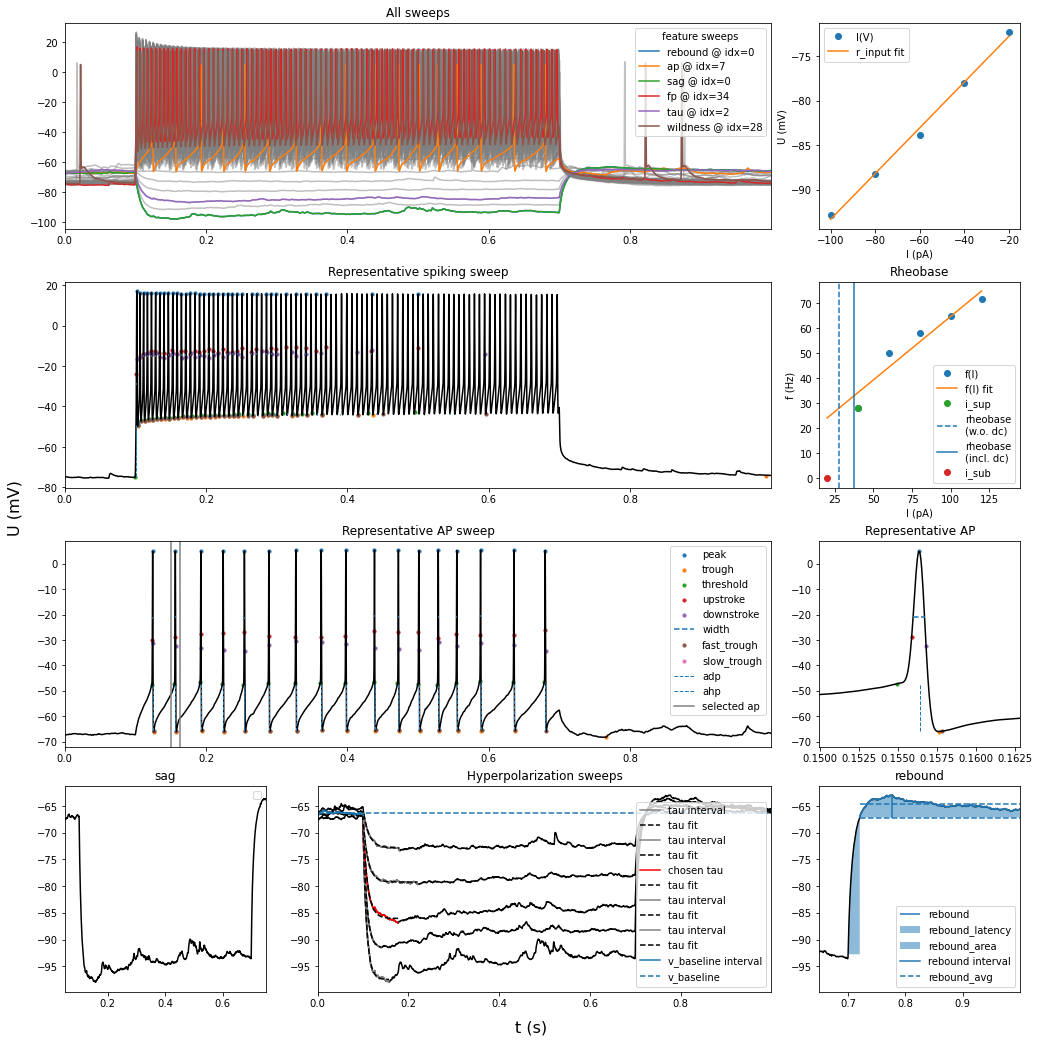

/home/jnsbck/Uni/PhD/projects/smartseq3/py_ephys/diagnostics.py:847: UserWarning: rebound_aps sweep plotting is not yet implemented yet!
  warnings.warn("rebound_aps sweep plotting is not yet implemented yet!")
/home/jnsbck/Uni/PhD/projects/smartseq3/py_ephys/diagnostics.py:1091: UserWarning: wildness sweep plotting is not yet implemented yet!
  warnings.warn("wildness sweep plotting is not yet implemented yet!")


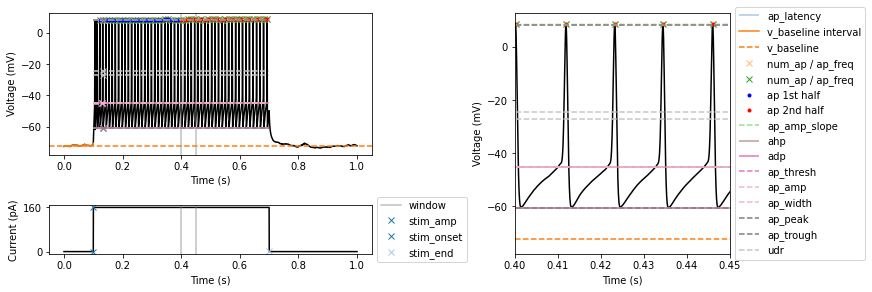

In [8]:
# since we compute diagnostics for sweep(set) features above we can also plot them
plot_sweepset_diagnostics(test_sweepset)
plt.show()

# Diagnostics for single sweeps can also be plotted
plot_sweep_diagnostics(test_sweepset.sweeps()[13])
plt.show()

In [9]:
# New sweep and sweepset features can be added via the @epyhs_feature decorator
print(get_example_feature.__doc__)

Extracts example ephys feature.

    depends on: feature_1, feature_2, ..., feature_n.
    description: This describes how the features gets computed.

    Example function definition
    '''
    @ephys_feature
    def get_example_feature(sweep_or_sweepset: Union[EphysSweepFeatureExtractor, EphysSweepSetFeatureExtractor])
        ft_value, ft_info = ephys_feature_init()  # init ft, ft_info = float("nan"), {}

        # do some feature calculations using sweep.
        ft_value = "some value"
        ft_info.update({"metadata": "contains intermediary results and feature metadata."})

        return ft_value, ft_info
    '''


    Args:
        sweep_or_sweepset (Union[EphysSweepFeatureExtractor, EphysSweepSetFeatureExtractor]): Sweep or sweepset to extract feature from.

    Returns:
        Tuple[float, Dict]: AP feature and optionally info
    
